# NMF Practical Work

**Roland Badeau - Notebook code by Umut Simsekli** 

Telecom Paris - TSIA 206

## 1. By following the technique that we used in the lecture, derive the MUR algorithm by yourselves

In [1]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display


C:\Users\maelm\AppData\Local\Temp\ipykernel_71244\1529239179.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(X)), origin="lower")


<Figure size 640x480 with 0 Axes>

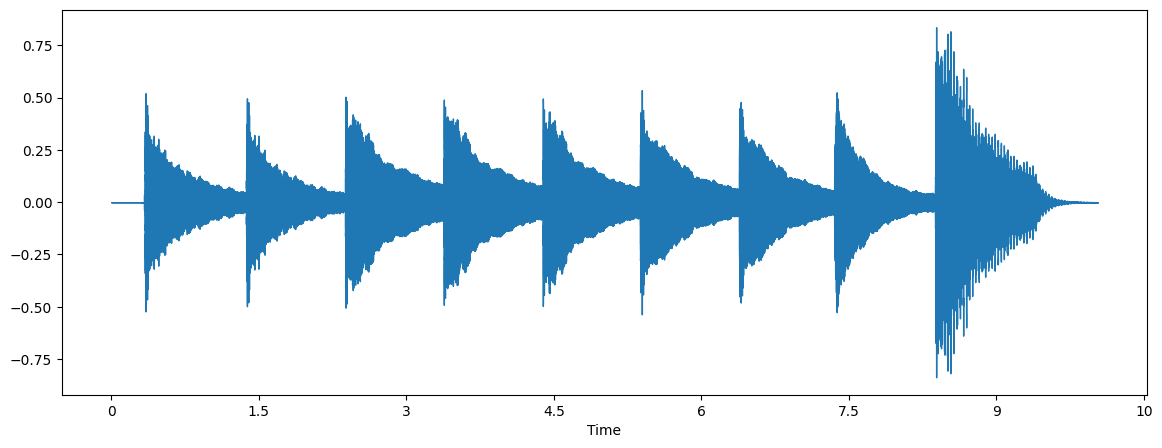

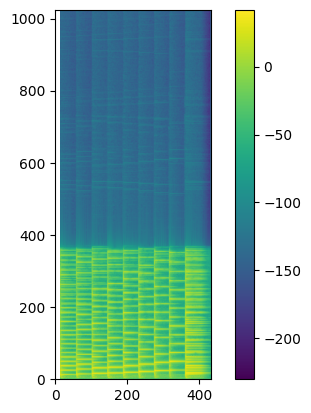

In [2]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(20*np.log10(np.abs(X)), origin="lower")
plt.colorbar()


### Mathemactical part:
We can rewrite the $\beta$-divergence this way: $\sum_i\sum_j d_{\beta}(x_{ij},\hat x_{ij}) = \sum_i\sum_j \frac{x_{ij}^\beta}{\beta(\beta-1)}-\frac{x_{ij}\hat x_{ij}^{\beta-1}}{\beta-1}+\frac {\hat x_{ij}^\beta}{\beta} = \frac{X^\beta}{\beta(\beta-1)}-\frac{X°\hat X^{\beta-1}}{\beta-1}+\frac{\hat X^\beta}{\beta} = d_{\beta}(X,\bar X) $\
With $\bar X = WH$ and ° being the term to term multiplication\
\
thus $\frac{\partial d_{\beta}}{\partial W} = 0 - X°\hat X^{\beta-2}H^T+\hat X^{\beta-1}H^T $ which would make the gradient descent algorithm look like this: \
$W = W -\eta *(- X°\hat X^{\beta-2}H^T+\hat X^{\beta-1}H^T) = W - \eta * (- X° (WH)^{\beta-2}H^T+(WH)^{\beta-1}H^T) $\
\
Then if we say $\eta = \frac{W}{(WH)^{\beta-1}H^T}$  we get the following update step: \
$W = W- \frac{W}{(WH)^{\beta-1}H^T}°(- X° (WH)^{\beta-2}H^T+(WH)^{\beta-1}H^T) = W + W°\frac{X° (WH)^{\beta-2}H^T}{(WH)^{\beta-1}H^T}-W  = W°\frac{X° (WH)^{\beta-2}H^T}{(WH)^{\beta-1}H^T} = W°\frac{X°\hat X^{\beta-2}H^T}{\hat X^{\beta-1}H^T}$\
\
\
The computation goes the same with H, except the $W^T$ goes to the left when we derivate $\hat X$ by H compared to when we did the same with W where the $H^T$ went out to the right.\
In the end we get the following update rule :\
$H = H°\frac{W^T(X°\hat X^{\beta-2})}{W^T\hat X^{\beta-1}} $

## 2. Implement MUR for NMF with beta-divergence 

In [3]:
def beta_div(X,Xb,beta):
    div = 0
    f,t = X.shape
    if beta == 0 or beta == 1:
        beta += 1e-8
    for i in range(f):
        for j in range(t):
            x = X[i,j]
            xb = Xb[i,j]
            div += (x**beta)/((beta-1)*beta)-(x*(xb**(beta-1)))/(beta-1)+(xb**beta)/beta
    return div

In [4]:
def MUR(X, beta=1, k=3, niter=1000):
    div = []
    f,t = X.shape
    W = np.random.rand(f,k)
    H = np.random.rand(k,t)
    Xb = W@H
    for i in range(niter):
        W *= ((X*((Xb+1e-8)**(beta-2)))@H.T)/(((Xb+1e-8)**(beta-1))@H.T)
        H *= (W.T@(X*((Xb+1e-8)**(beta-2))))/(W.T@((Xb+1e-8)**(beta-1)))
        Xb = W@H
        div.append(beta_div(X,Xb,beta))
    
    return W,H,div

A= [[0.06029298 0.406809  ]
 [0.78340841 0.87049348]
 [0.68312613 0.43495723]
 [0.28622492 0.55626603]]
W= [[0.00984752 0.35015277]
 [0.83990451 0.42803557]
 [0.78465108 0.07069613]
 [0.26845366 0.37876418]]
H= [[0.90449875 0.47563277]
 [0.15623925 1.21243486]]
Ab= [[0.06361468 0.42922122]
 [0.82656854 0.91845136]
 [0.72076143 0.45892022]
 [0.30199383 0.58691225]]


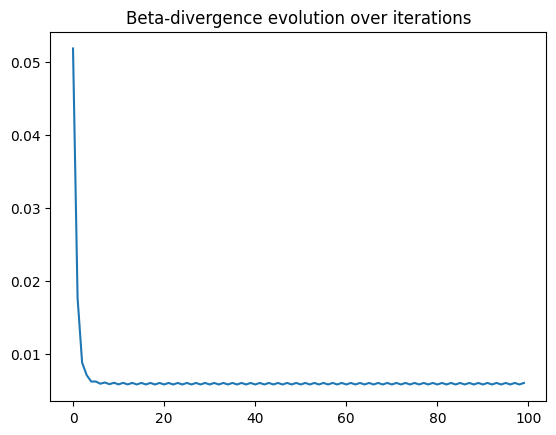

In [5]:
# Test on small random data
a = np.random.rand(4,2)
print('A=',a)
w,h,div = MUR(a,1,2,100)
print('W=',w)
print('H=',h)
ab = w@h
print('Ab=',ab)
plt.plot(div)
plt.title('Beta-divergence evolution over iterations')
plt.show()

Number of very good tests: 6


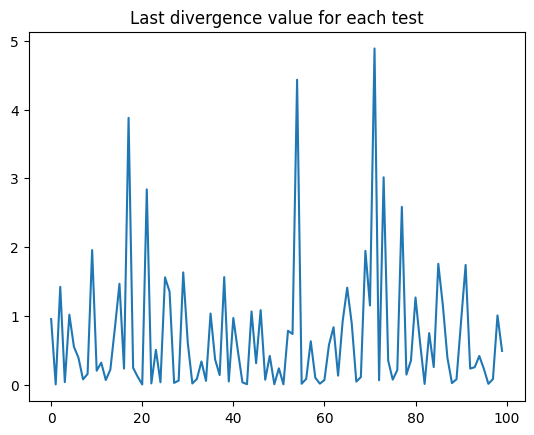

In [6]:
# Test stability by doing 100 tests like above and plotting the final divergence value of each test
e = []
countgood = 0
for i in range(100):
    a = np.random.rand(4,2)
    w,h,d = MUR(a,1,2,100)
    ab = w@h
    l = d[-1]
    e.append(l)
    if l<0.01:
        countgood+=1
print('Number of very good tests:',countgood)
plt.plot(e)
plt.title('Last divergence value for each test')
plt.show()

## 3. Experiment with the algorithm parameters, such as $\beta$, number of columns in $W$, STFT window size, hop size, etc. 

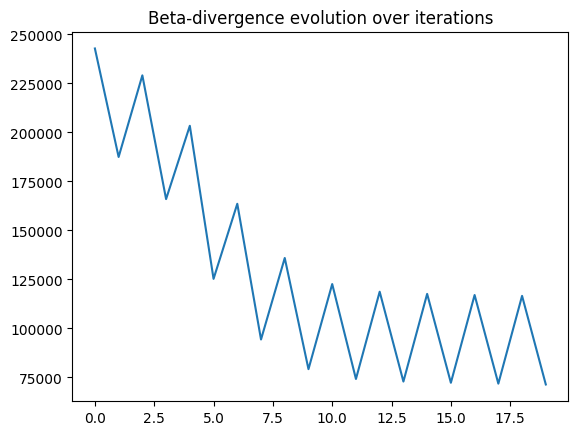

In [11]:
K = 8
W,H,div = MUR(X,1,K,20)
Xb = W@H
plt.plot(div)
plt.title('Beta-divergence evolution over iterations')
plt.show()

## 4. Reconstruct each musical note separately

In [13]:
notes = []
for i in range(K):
    notestft = X*((np.outer(W[:,i],H[i,:]))/(Xb+1e-8))
    note = librosa.istft(notestft)
    notes.append(note)

In [14]:
ipd.Audio(notes[2],rate=sr)

In [15]:
# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)
